In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import datetime
import matplotlib.dates as mdates

In [5]:
filepath = "/Users/kassiewang/GitHub/cds/Kassie/422coronaclean.csv"
rawcorona = pd.read_csv(filepath, error_bad_lines=False)

cleancorona = rawcorona[rawcorona['Country.Region'].str.contains('US', case = True, regex = True)]
cleancorona.drop('Country.Region', 1, inplace = True)
cleancorona['ObservationDate'] = pd.to_datetime(cleancorona['ObservationDate'])
cleancorona.rename(columns = {'ObservationDate':'date'}, inplace = True)

b'Skipping line 3: expected 5 fields, saw 6\nSkipping line 625: expected 5 fields, saw 6\nSkipping line 626: expected 5 fields, saw 6\nSkipping line 627: expected 5 fields, saw 6\nSkipping line 2972: expected 5 fields, saw 6\nSkipping line 2973: expected 5 fields, saw 6\nSkipping line 2974: expected 5 fields, saw 6\nSkipping line 2975: expected 5 fields, saw 6\n'
/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [6]:
rawtweets = pd.read_csv("/Users/kassiewang/GitHub/cds/final_csv/us.csv")
rawtweets = rawtweets.drop(rawtweets.columns[[0]], axis = 1)
rawtweets['Date'] = rawtweets['Date'].str[:10]
rawtweets['Date'] = pd.to_datetime(rawtweets['Date'], errors='coerce')
rawtweets.rename(columns = {'Date': 'date'}, inplace = True)

tweetct = rawtweets.groupby(['date']).agg('count')
tweetct.rename(columns = {'Text':'tweetct'}, inplace = True)

In [7]:
finaldf = pd.merge(tweetct, cleancorona, how='inner', on = 'date')
finaldf

,date,tweetct,Confirmed,Deaths,Recovered
0,2020-02-19,30,15,0,3
1,2020-02-20,10,15,0,3
2,2020-02-21,5,35,0,5
3,2020-02-22,30,35,0,5
4,2020-02-23,10,35,0,5
...,...,...,...,...,...
58,2020-04-17,327,699706,36773,58545
59,2020-04-18,260,732197,38664,64840
60,2020-04-19,258,759086,40661,70337
61,2020-04-20,332,784326,42094,72329


/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


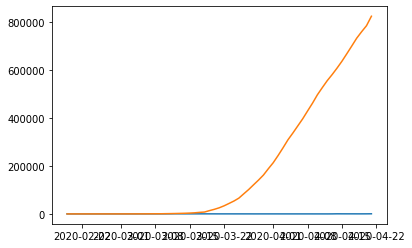

In [41]:
plt.plot('date', 'tweetct', data=finaldf)
plt.plot('date', 'Confirmed', data=finaldf)


In [8]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import nltk
import re
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from itertools import islice
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc = [word.lower() for word in nopunc.split()
              if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

df_clean = pd.read_csv("/Users/kassiewang/GitHub/cds/final_csv/us.csv")
df_clean.rename(columns = {'Text':'cleaned_text'}, inplace = True)
df_clean = df_clean.dropna()

def nlp(df):
    # lowercase everything
    # get rid of '\n' from whitespace
    # regex remove hyperlinks
    # removing '&gt;'
    # check for emojis
    # remove emojis
    # remove punctuation
    # remove ' s ' from removing punctuation

    # regex remove hyperlinks
    df['cleaned_text'] = df['cleaned_text'].str.replace(
        'http\S+|www.\S+', '', case=False)
    # removing '&gt;'
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: x.replace('&gt;', ''))
    # remove ' s ' that was created after removing punctuations
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: str(x).replace(" s ", " "))
    return df


train_df = nlp(df_clean)
train_comments = train_df['cleaned_text']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kassiewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kassiewang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
vectorizer = TfidfVectorizer(analyzer=text_process,ngram_range=(1,3))
tfidfconvert = vectorizer.fit(train_comments)
X_transformed = tfidfconvert.transform(train_comments)

In [38]:
#TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')
def cos_similarity(textlist):
    tfidf = vectorizer.fit_transform(textlist)
    return (tfidf * tfidf.T).toarray()
cos_similarity_matrix = cos_similarity(train_comments)

In [39]:
import seaborn as sns

heatplot = sns.heatmap(cos_similarity_matrix, linewidth=0.5)
plt.show()

KeyboardInterrupt: 

In [43]:
cos_similarity_matrix.shape

(10402, 10402)